<a href="https://colab.research.google.com/github/bharathraj-v/geoml-wd/blob/main/notebooks/fasterRCNN_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing dependencies

In [ ]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 285551, done.
remote: Counting objects: 100% (6677/6677), done.
remote: Compressing objects: 100% (405/405), done.
remote: Total 285551 (delta 6321), reused 6583 (delta 6258), pack-reused 278874
Receiving objects: 100% (285551/285551), 571.11 MiB | 16.69 MiB/s, done.
Resolving deltas: 100% (261446/261446), done.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

## Repurposing Masks into Bounding Boxes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!cp /content/drive/MyDrive/PV01_pngs.zip /content/
!unzip PV01_pngs.zip

In [ ]:
images_path = "/content/images"
mask_path = "/content/masks"

images = []
masks = []

for root, dirs, files in os.walk(images_path):
    for file in files:
        images.append(os.path.join(root, file))

for root, dirs, files in os.walk(mask_path):
    for file in files:
        masks.append(os.path.join(root, file))



images = sorted(images, key=lambda x: int(x.split("/")[-1].split(".")[0]))
masks = sorted(masks, key=lambda x: int(x.split("/")[-1].split(".")[0]))

In [ ]:
images[:10]

['/content/images/0.png',
 '/content/images/1.png',
 '/content/images/2.png',
 '/content/images/3.png',
 '/content/images/4.png',
 '/content/images/5.png',
 '/content/images/6.png',
 '/content/images/7.png',
 '/content/images/8.png',
 '/content/images/9.png']

In [ ]:
import cv2
import torchvision
from torchvision.utils import draw_bounding_boxes
import imutils
from torchvision.ops import masks_to_boxes
from torchvision.io import read_image

In [ ]:
def get_bbx_from_mask(image_path, mask_path):
    sample_mask = cv2.imread(mask_path)
    gray = cv2.cvtColor(sample_mask, cv2.COLOR_BGR2GRAY)
    contours = cv2.findContours(gray.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(contours)
    bounding_boxes = []
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        bounding_boxes.append([x,y,w,h])
    if len(cnts) == 0:
      bounding_boxes = [[0,0,0,0]]
    bounding_boxes = torch.FloatTensor(bounding_boxes)
    bounding_boxes =  torchvision.ops.box_convert(bounding_boxes, in_fmt="xywh", out_fmt="xyxy")
    drawn_boxes = draw_bounding_boxes(read_image(image_path), bounding_boxes, colors="red")
    return bounding_boxes, drawn_boxes

In [ ]:
from PIL import Image


class PanelDataset(torch.utils.data.Dataset):
    def __init__(self, root, width=256, height=256, transforms=None):
        self.root = root
        self.transforms = transforms
        self.height = height
        self.width = width
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images")), key=lambda x: int(x.split("/")[-1].split(".")[0])))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks")), key=lambda x: int(x.split("/")[-1].split(".")[0])))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])

        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)

        img_res /= 255.0

        boxes, drawn_boxes = get_bbx_from_mask(img_path, mask_path)


        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {}
        target["iscrowd"] = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area

        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms is not None:
             sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
             img_res = sample['image']
             target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = PanelDataset("/content", 256, 256)
img, target = dataset[119]
print(img.shape, target)

(256, 256, 3) {'iscrowd': tensor([0, 0]), 'boxes': tensor([[100.,  42., 222., 110.],
        [ 78.,   0., 144.,  19.]]), 'labels': tensor([1, 1]), 'area': tensor([8296., 1254.]), 'image_id': tensor([119])}


In [ ]:
len(dataset)

645

In [ ]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes'].cpu()):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

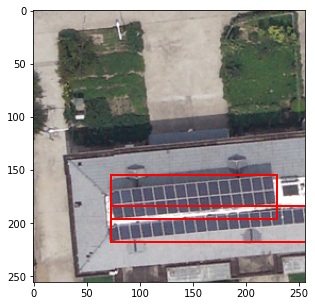

In [ ]:
dataset = PanelDataset("/content", 256, 256)

img, target = dataset[25]
plot_img_bbox(img, target)

Checking and cleaning the dataset

In [ ]:
boxes = {}

blanks = []

for i in range(len(PanelDataset("/content", 256, 256))):
  boxes[i]= (PanelDataset("/content", 256, 256)[i][1]['boxes'])
  if boxes[i].cpu().detach().numpy().any() == torch.FloatTensor([[0,0,0,0]]).detach().numpy().any(): blanks.append(i)

In [ ]:
blanks

[24, 84, 610]

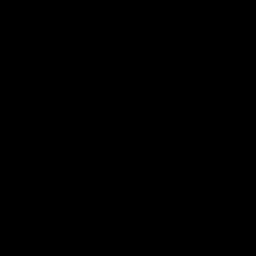

In [ ]:
Image.open(masks[24])

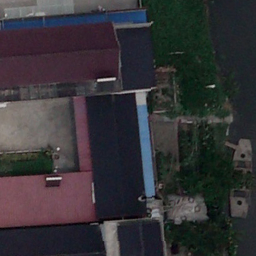

In [ ]:
Image.open(images[24])

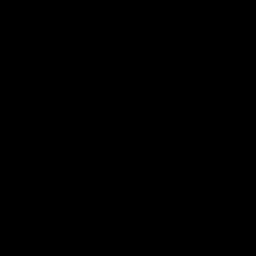

In [ ]:
Image.open(masks[84])

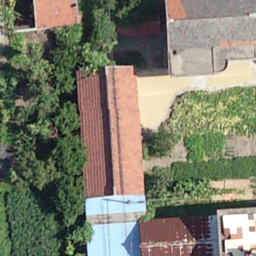

In [ ]:
Image.open(images[84])

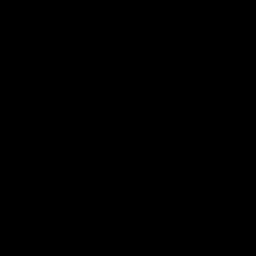

In [ ]:
Image.open(masks[610])

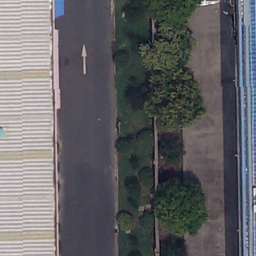

In [ ]:
Image.open(images[610])

In [ ]:
os.remove("/content/masks/24.png")
os.remove("/content/masks/84.png")
os.remove("/content/masks/610.png")
os.remove("/content/images/24.png")
os.remove("/content/images/84.png")
os.remove("/content/images/610.png")

## FastRCNN

### Importing Dependencies for FastRCNN

### Model

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

### Data Augmentation

In [ ]:
def get_transform(train):
    if train:
        return A.Compose([
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  

### Preparing the Dataset

In [ ]:
dataset = PanelDataset('/content', 256, 256, transforms= get_transform(train=True))
dataset_test = PanelDataset('/content', 256, 256, transforms= get_transform(train=False))


# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)



### Training

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 4

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/52]  eta: 0:08:12  lr: 0.000103  loss: 2.3683 (2.3683)  loss_classifier: 1.0019 (1.0019)  loss_box_reg: 0.4021 (0.4021)  loss_objectness: 0.8982 (0.8982)  loss_rpn_box_reg: 0.0662 (0.0662)  time: 9.4628  data: 0.8091  max mem: 8186
Epoch: [0]  [10/52]  eta: 0:01:41  lr: 0.001082  loss: 1.7598 (2.0365)  loss_classifier: 0.7810 (0.7094)  loss_box_reg: 0.4385 (0.4241)  loss_objectness: 0.6174 (0.7533)  loss_rpn_box_reg: 0.1375 (0.1498)  time: 2.4054  data: 0.0942  max mem: 8454
Epoch: [0]  [20/52]  eta: 0:01:06  lr: 0.002062  loss: 1.1297 (1.5863)  loss_classifier: 0.4201 (0.5414)  loss_box_reg: 0.4748 (0.4528)  loss_objectness: 0.1499 (0.4576)  loss_rpn_box_reg: 0.1233 (0.1345)  time: 1.7109  data: 0.0273  max mem: 8454
Epoch: [0]  [30/52]  eta: 0:00:43  lr: 0.003041  loss: 0.9110 (1.3046)  loss_classifier: 0.2185 (0.4186)  loss_box_reg: 0.4037 (0.4115)  loss_objectness: 0.0930 (0.3386)  loss_rpn_box_reg: 0.1020 (0.1360)  time: 1.7293  data: 0.0315  max mem: 8454
Epoch: [

In [ ]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:


# pick one image from the test set
img, target = dataset_test[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))




predicted #boxes:  29
real #boxes:  2


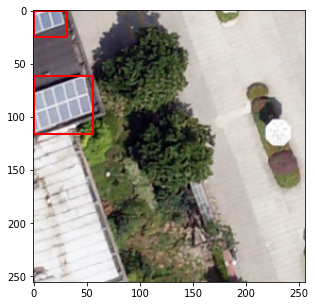

In [ ]:
plot_img_bbox(torch_to_pil(img), target)

#### Predicted output:

In [58]:
nms_prediction = apply_nms(prediction, iou_thresh=0.01)
nms_prediction

{'boxes': tensor([[0.0000e+00, 0.0000e+00, 3.1202e+01, 2.4036e+01],
         [1.2201e-01, 6.0972e+01, 5.9205e+01, 1.1422e+02],
         [2.5598e+02, 8.8679e+01, 2.5600e+02, 9.3514e+01],
         [2.5596e+02, 2.3490e+02, 2.5600e+02, 2.4258e+02],
         [2.5597e+02, 2.4372e+02, 2.5600e+02, 2.4818e+02],
         [2.5596e+02, 2.3109e+02, 2.5600e+02, 2.3320e+02],
         [2.5599e+02, 3.4212e+01, 2.5600e+02, 4.0352e+01],
         [2.5389e+02, 2.5593e+02, 2.5552e+02, 2.5600e+02],
         [2.5589e+02, 1.9322e+02, 2.5600e+02, 2.0411e+02],
         [2.5590e+02, 1.4229e+01, 2.5600e+02, 2.0377e+01],
         [2.5591e+02, 1.6994e+02, 2.5600e+02, 1.7763e+02],
         [1.9669e+02, 2.5581e+02, 2.0081e+02, 2.5599e+02]], device='cuda:0'),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9993, 0.9985, 0.2217, 0.2217, 0.2217, 0.2217, 0.2217, 0.1515, 0.0769,
         0.0640, 0.0598, 0.0521], device='cuda:0')}

In [ ]:
len(nms_prediction['boxes'])

12

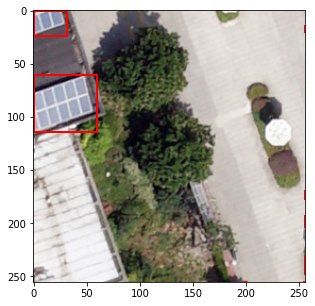

In [ ]:
plot_img_bbox(torch_to_pil(img), nms_prediction)

#### Comparing predictions to original bounding boxes
---



Original Bounding Box(s)


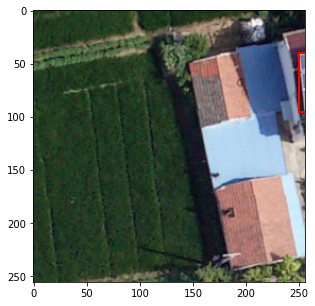

Predicted Bounding Box(s)


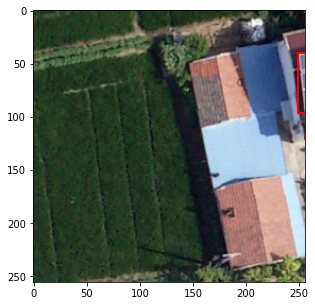

Original Bounding Box(s)


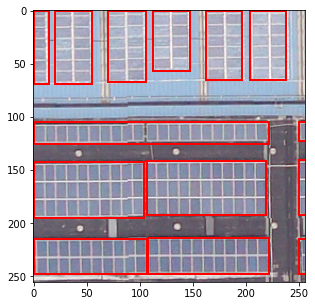

Predicted Bounding Box(s)


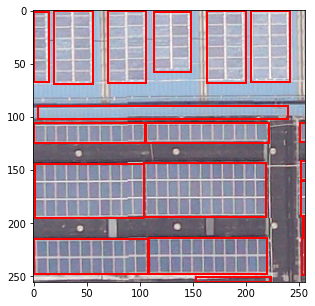

Original Bounding Box(s)


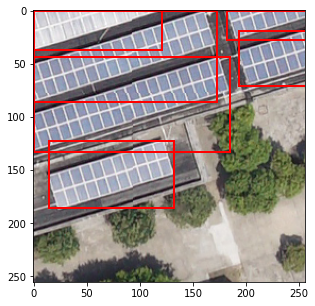

Predicted Bounding Box(s)


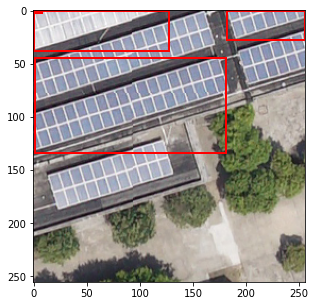

Original Bounding Box(s)


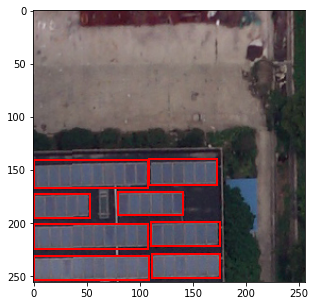

Predicted Bounding Box(s)


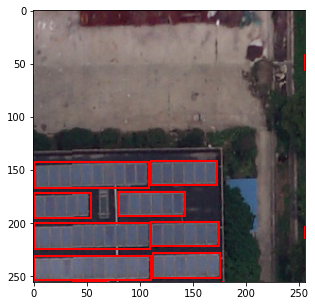

Original Bounding Box(s)


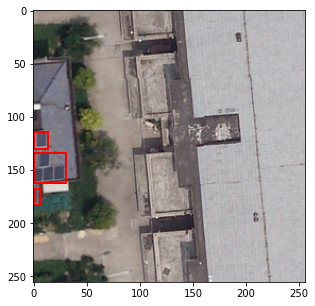

Predicted Bounding Box(s)


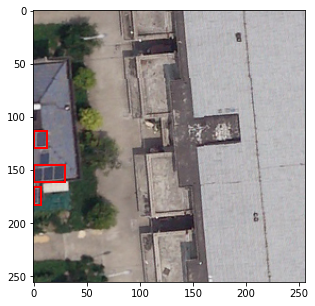

Original Bounding Box(s)


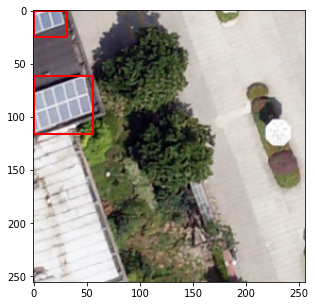

Predicted Bounding Box(s)


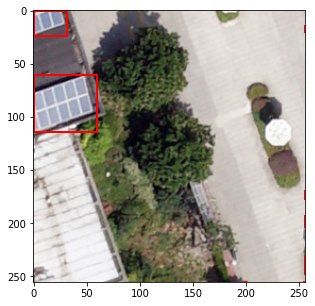

In [59]:
for i in range(6):
  img, target = dataset_test[i]
  model.eval()
  with torch.no_grad():
      prediction = model([img.to(device)])[0]
  nms_prediction = apply_nms(prediction, iou_thresh=0.02)
  print("Original Bounding Box(s)")
  plot_img_bbox(torch_to_pil(img), target)
  print("Predicted Bounding Box(s)")
  plot_img_bbox(torch_to_pil(img), nms_prediction)